In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib

# Load the CSV file containing PTID and target variable
csv_file = '/Users/zc56/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)

# Extract PTID and target values from the DataFrame
ptid_csv = df['PTID'].values
y_variable = df['RAVLT_forgetting'].values

# Directory containing the image files
directory = '/Users/zc56/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize lists for storing matched images and corresponding y values
matched_images = []
matched_y_values = []
matched_ptids = []  # To store the PTIDs that have been matched

# Loop through PTIDs in the CSV order and try to find corresponding image
for i, ptid_csv_entry in enumerate(ptid_csv):
    # Find image files that match the PTID in the CSV
    ptid_csv_entry = ptid_csv_entry.strip()  # Remove any accidental whitespace
    
    # Construct the expected filename format (e.g., '002_S_0295.nii.gz')
    image_filename = f"{ptid_csv_entry}.nii.gz"
    file_path = os.path.join(directory, image_filename)
    
    # Check if the image file exists in the directory
    if os.path.exists(file_path):
        # Get the corresponding target value
        y_value = y_variable[i]
        
        # Skip if the corresponding y_value is NaN
        if np.isnan(y_value):
            print(f"Skipping PTID '{ptid_csv_entry}' because y_value is NaN.")
            continue
        
        # Load the image
        img = nib.load(file_path)
        data = img.get_fdata()

        # Append the image data, y_value, and PTID to the lists
        matched_images.append(data)
        matched_y_values.append(y_value)
        matched_ptids.append(ptid_csv_entry)  # To track the matched PTIDs
    else:
        print(f"Image for PTID '{ptid_csv_entry}' not found in the directory.")

# Convert the matched images and y values into arrays
if matched_images:
    image_tensor = np.stack(matched_images, axis=0)
    y_variable = np.array(matched_y_values)
    matched_ptids = np.array(matched_ptids)  # Convert PTIDs to an array for alignment checks
    
    print(f"Aligned image tensor shape: {image_tensor.shape}")
    print(f"Aligned y variable shape: {y_variable.shape}")
    print(f"Aligned PTID shape: {matched_ptids.shape}")
else:
    print("No images matched.")

# Optional: Print the first few PTIDs, y values, and image shapes to verify alignment
print(f"First 5 matched PTIDs: {matched_ptids[:5]}")
print(f"First 5 y values: {y_variable[:5]}")
print(f"First image shape: {image_tensor[0].shape if image_tensor.size > 0 else 'No images loaded'}")

Skipping PTID '073_S_0311' because y_value is NaN.
Skipping PTID '099_S_0372' because y_value is NaN.
Skipping PTID '141_S_0853' because y_value is NaN.
Skipping PTID '141_S_1094' because y_value is NaN.
Aligned image tensor shape: (814, 48, 48, 48)
Aligned y variable shape: (814,)
Aligned PTID shape: (814,)
First 5 matched PTIDs: ['002_S_0295' '002_S_0413' '002_S_0559' '002_S_0619' '002_S_0685']
First 5 y values: [3. 5. 1. 4. 3.]
First image shape: (48, 48, 48)


In [2]:
# sliced 3D real image
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split

model with correct y order

In [4]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)
const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=10, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .01
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(569, 48, 48, 48) (569,)
mean train RSE:  0.245049388898607
CP train RSE:  0.00021162202356280656
Tucker train RSE:  0.002195348007927589
mean test RSE:  1.5351596618044785
CP test RSE:  2.142961869882348
Tucker test RSE:  2.125720659253715


model with y shuffled

In [7]:
shuffled_y_variable = np.random.permutation(y_variable)
X_train, X_test, y_train, y_test = train_test_split(image_tensor, shuffled_y_variable, test_size=0.3, random_state=42)
const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=10, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .01
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))


(569, 48, 48, 48) (569,)
mean train RSE:  0.28155329440635635
CP train RSE:  0.00019911205720434777
Tucker train RSE:  0.00027928540039957915
mean test RSE:  1.4549138318396397
CP test RSE:  2.057783584590412
Tucker test RSE:  2.036227499929981


CP_Regressor on dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)
regmodel = CPRegressor(weight_rank=3)
regmodel.fit(X_train, y_train)
y_predict = model.predict(X_train)


In [14]:
print((tl.norm(y_train - y_predict)/len(y_train))/np.var(y_train))

0.02356988111943008


In [15]:
print((tl.norm(y_test - model.predict(X_test))/len(y_test))/np.var(y_test))

0.03371621710493336


Recovery of coefficients learned by CP_Regressor

In [19]:
# Retrieve and print the learned CP decomposition weights
cp_weights = regmodel.cp_weight_
print("Learned CP weights (cp_weight_):")
print(cp_weights)

# Retrieve and print the learned tensor of weights
weight_tensor = regmodel.weight_tensor_
print("Learned weight tensor (weight_tensor_):")
print(weight_tensor)

Learned CP weights (cp_weight_):
(array([1., 1., 1.]), [array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.14205055e+00, -1.24137215e+00,  6.54705128e-02],
       [-9.33037612e-02, -4.19421110e-02, -1.18354367e-02],
       [ 7.75482122e-03,  4.27888754e-03, -7.21525381e-03],
       [ 6.81809533e-02,  7.07093825e-02, -7.16651451e-03],
       [ 1.11387567e-01,  5.15047307e-02,  1.78449208e-02],
       [-1.66674274e-01, -3.01650399e-02, -5.67677800e-02],
       [ 1.06567164e-01,  4.39684142e-02,  5.57728994e-02],
       [ 8.57888733e-02,  5.84657269e-02,  4.28446945e-02],
       [ 1.81361641e-02, -6.24375654e-03, -4.11031058e-02],
       [-3.98727304e-02, -2.66874483e-02,  3.68640675e-02],
       [-1.11552090e-02,  6.68531137e-02, -6.46694199e-02],
       [ 6.84433639e-03, -1.08011551e-01,  3.37212771e-02],
       [-4.11279396e-02,  1.20007811e-02,  2.93738714e-02],
       [ 9.79362041e-02, -3.68800296e-02,  1.43811668e-02],
       [-1.32889612e-01, -3.55232451e-03, -1

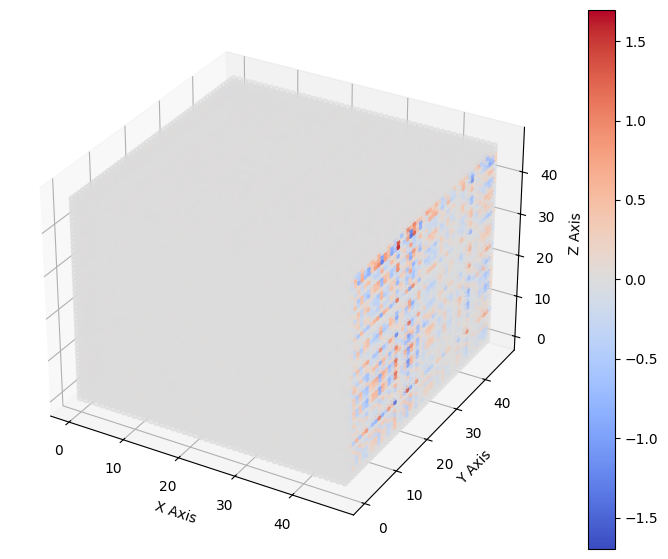

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume `weight_tensor_` is the learned weight tensor
# We'll plot one slice of it or specific parts of it for better visualization

# Extract dimensions of the tensor
tensor_shape = weight_tensor.shape

# Create a grid of coordinates corresponding to the indices of the tensor
x = np.arange(tensor_shape[0])
y = np.arange(tensor_shape[1])
z = np.arange(tensor_shape[2])

# Create a 3D meshgrid for plotting
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Flatten the arrays to use them in scatter plot
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
weights_flat = weight_tensor.flatten()

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: X, Y, Z represent the coordinates and weights_flat is the value at each point
sc = ax.scatter(X_flat, Y_flat, Z_flat, c=weights_flat, cmap='coolwarm')

# Add color bar to represent the scale of coefficients
plt.colorbar(sc, ax=ax)

# Labels for axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()

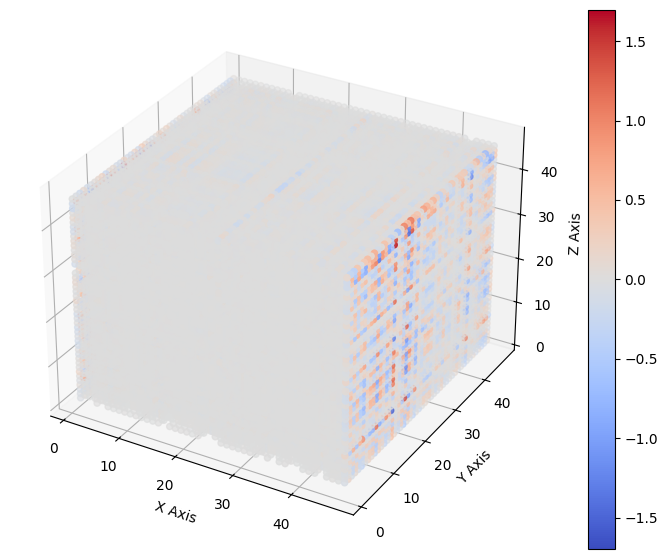

In [21]:
# Threshold to filter out near-zero values for clearer plotting
threshold = 1e-3

# Filter values based on the threshold
non_zero_indices = np.abs(weights_flat) > threshold

# Plot only non-zero (or significant) values
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for non-zero values
sc = ax.scatter(X_flat[non_zero_indices], Y_flat[non_zero_indices], Z_flat[non_zero_indices], 
                c=weights_flat[non_zero_indices], cmap='coolwarm')

plt.colorbar(sc, ax=ax)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()